Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("skin_cancer_data/Train/")
data_dir_test = pathlib.Path('skin_cancer_data/Test/')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train, validation_split=0.2,subset='training',seed=123,image_size=(img_width,img_height), batch_size=32)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train, validation_split=0.2,subset='validation',seed=123,image_size=(img_width,img_height), batch_size=32)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

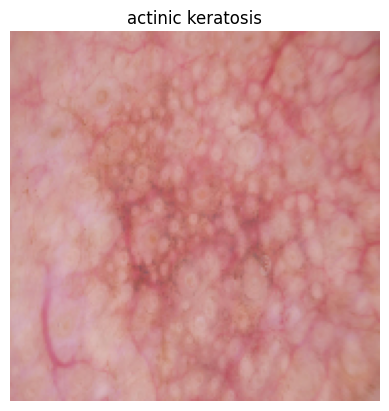

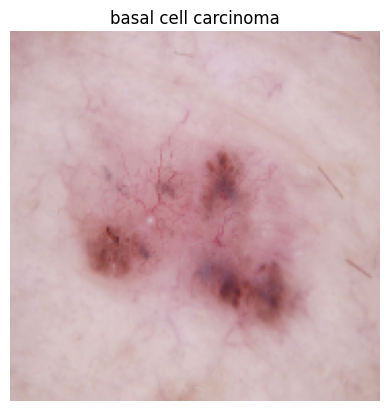

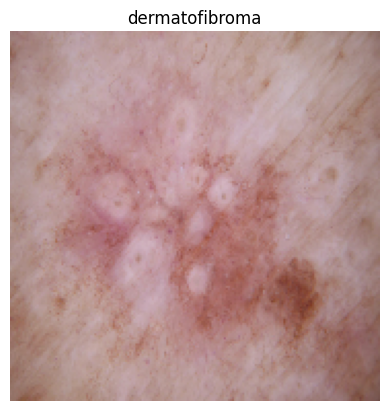

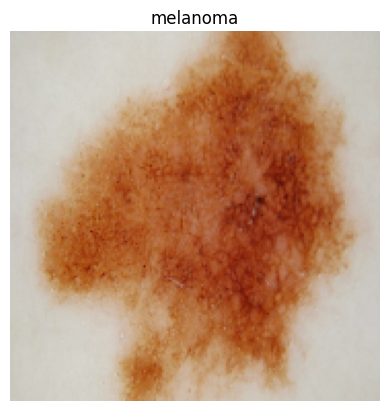

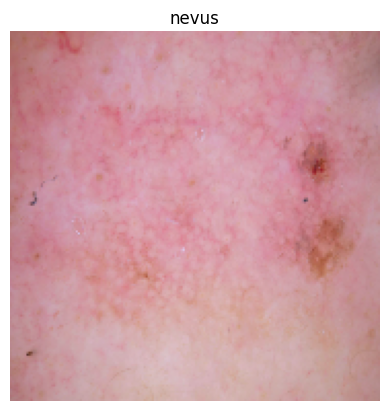

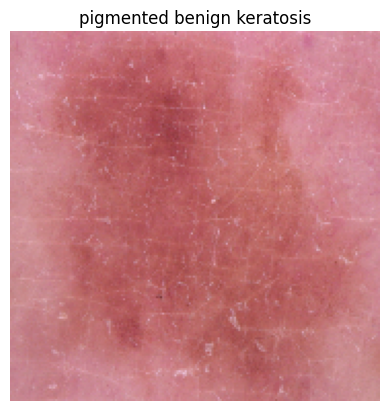

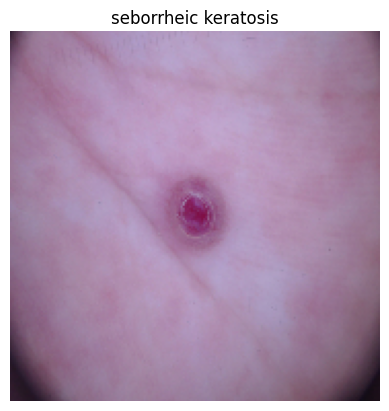

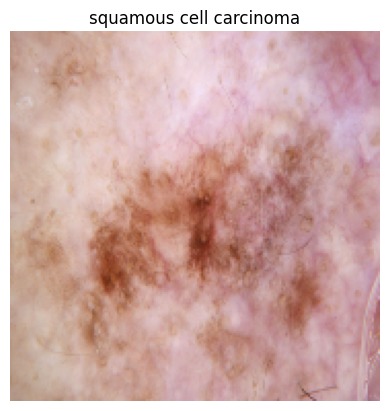

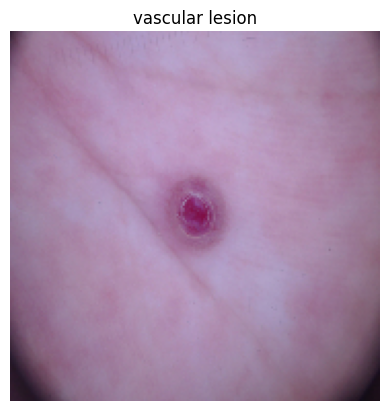

In [8]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# Extract one batch from the dataset
for images, labels in train_ds.take(1):
    # Plot one image from each class
    num_classes = len(class_names)
    
    for i in range(num_classes):
        # Find the index of the first occurrence of the class in the batch
        index = tf.argmax(tf.cast(labels == i, dtype=tf.int32))
        
        # Extract the corresponding image
        image = images[index].numpy().astype("uint8")

        # Plot the image
        plt.imshow(image)
        plt.title(class_names[i])
        plt.axis("off")
        plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [10]:
### Your code goes here
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional: Dropout for regularization

# Output layer
num_classes = 9
model.add(layers.Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [11]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [13]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 29s 465ms/step - loss: 2.0691 - accuracy: 0.2210 - val_loss: 1.9769 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 26s 455ms/step - loss: 1.7965 - accuracy: 0.3566 - val_loss: 1.6442 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 25s 449ms/step - loss: 1.6117 - accuracy: 0.4325 - val_loss: 1.4707 - val_accuracy: 0.5168
Epoch 4/20
56/56 [==============================] - 25s 446ms/step - loss: 1.4941 - accuracy: 0.4760 - val_loss: 1.4993 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 25s 453ms/step - loss: 1.4080 - accuracy: 0.5190 - val_loss: 1.3750 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 25s 453ms/step - loss: 1.3642 - accuracy: 0.5173 - val_loss: 1.3913 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 26s 464ms/step - loss: 1.3317 - accuracy: 0.5402 - val_loss: 1.3463 - val_accuracy: 0.5324

### Visualizing training results

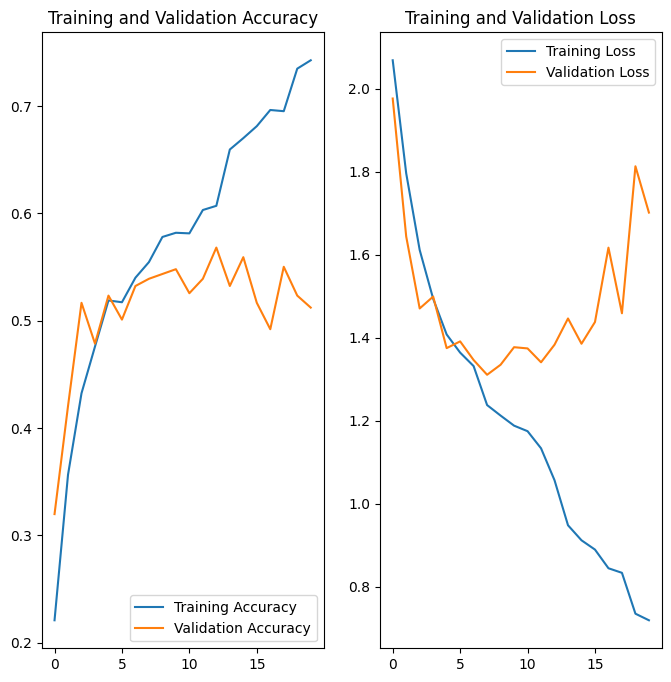

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Findings
The model appears to be underfitting and validation loss is steadily increasing as we go across epochs

In [15]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data will be used for validation
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Flow training images with data augmentation and validation split
train_generator = train_datagen.flow_from_directory(
    'skin_cancer_data/Train/',
    target_size=(180, 180),
    batch_size=32,
    class_mode='sparse',
    subset='training'  
)

# Flow validation images with data augmentation and validation split
validation_generator = val_datagen.flow_from_directory(
    'skin_cancer_data/Train/',
    target_size=(180, 180),
    batch_size=32,
    class_mode='sparse',
    subset='validation'  
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


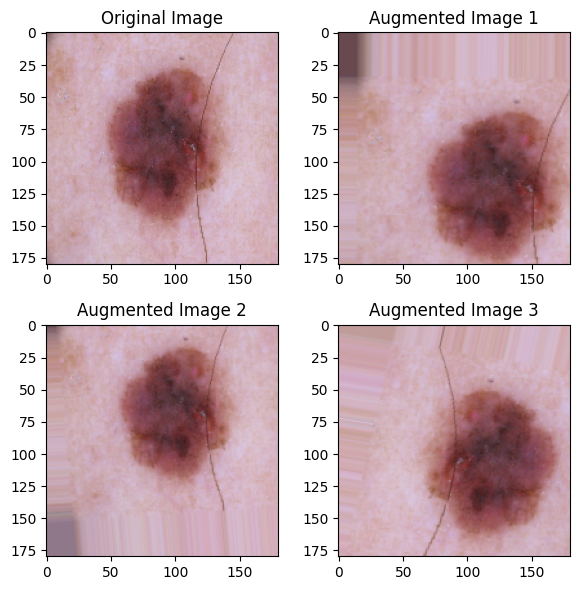

In [16]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load one image for visualization
img_path = 'skin_cancer_data/Train/melanoma/ISIC_0000139.jpg'
img = image.load_img(img_path, target_size=(180, 180))

# Convert the image to a NumPy array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Create an instance of the ImageDataGenerator with the augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Visualize the original image
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Apply data augmentation and visualize the transformed images
augmentation_iterator = datagen.flow(img_array, batch_size=1)

for i in range(3):
    augmented_img = augmentation_iterator.next()[0]
    plt.subplot(2, 2, i + 2)
    plt.imshow(augmented_img)
    plt.title(f'Augmented Image {i + 1}')

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [17]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional: Dropout for regularization

# Output layer
num_classes = 9
model.add(layers.Dense(num_classes, activation='softmax'))


### Compiling the model

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [19]:
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
57/57 [==============================] - 40s 681ms/step - loss: 2.0755 - accuracy: 0.1916 - val_loss: 2.0347 - val_accuracy: 0.2072
Epoch 2/20
57/57 [==============================] - 38s 672ms/step - loss: 2.0454 - accuracy: 0.1972 - val_loss: 2.0164 - val_accuracy: 0.2072
Epoch 3/20
57/57 [==============================] - 38s 668ms/step - loss: 2.0331 - accuracy: 0.1939 - val_loss: 2.0205 - val_accuracy: 0.1959
Epoch 4/20
57/57 [==============================] - 41s 713ms/step - loss: 2.0416 - accuracy: 0.1877 - val_loss: 2.0553 - val_accuracy: 0.1959
Epoch 5/20
57/57 [==============================] - 38s 665ms/step - loss: 2.0490 - accuracy: 0.1967 - val_loss: 2.0272 - val_accuracy: 0.2072
Epoch 6/20
57/57 [==============================] - 38s 674ms/step - loss: 2.0285 - accuracy: 0.2006 - val_loss: 2.0146 - val_accuracy: 0.2072
Epoch 7/20
57/57 [==============================] - 38s 665ms/step - loss: 2.0298 - accuracy: 0.1939 - val_loss: 2.0127 - val_accuracy: 0.2072

### Visualizing the results

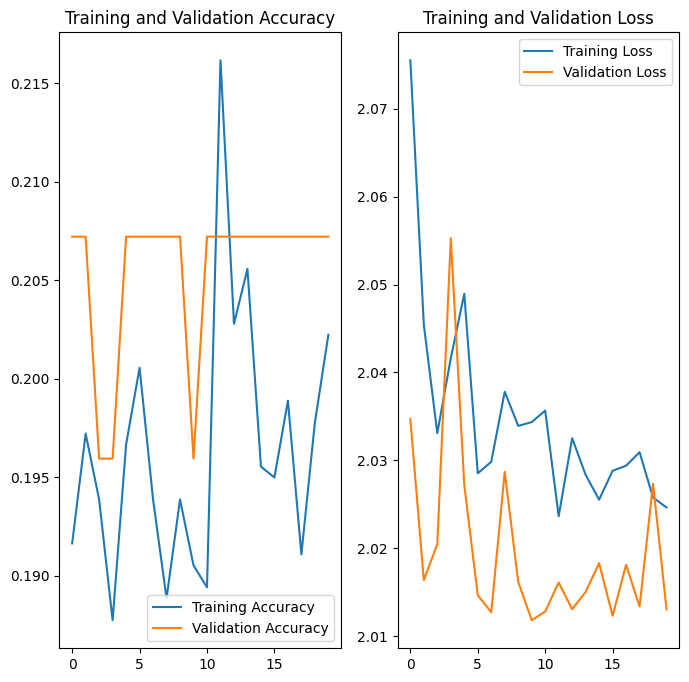

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The data augmentation strategy has yielded a severely underfit model, indicating that the model we have chosen might be too simple.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

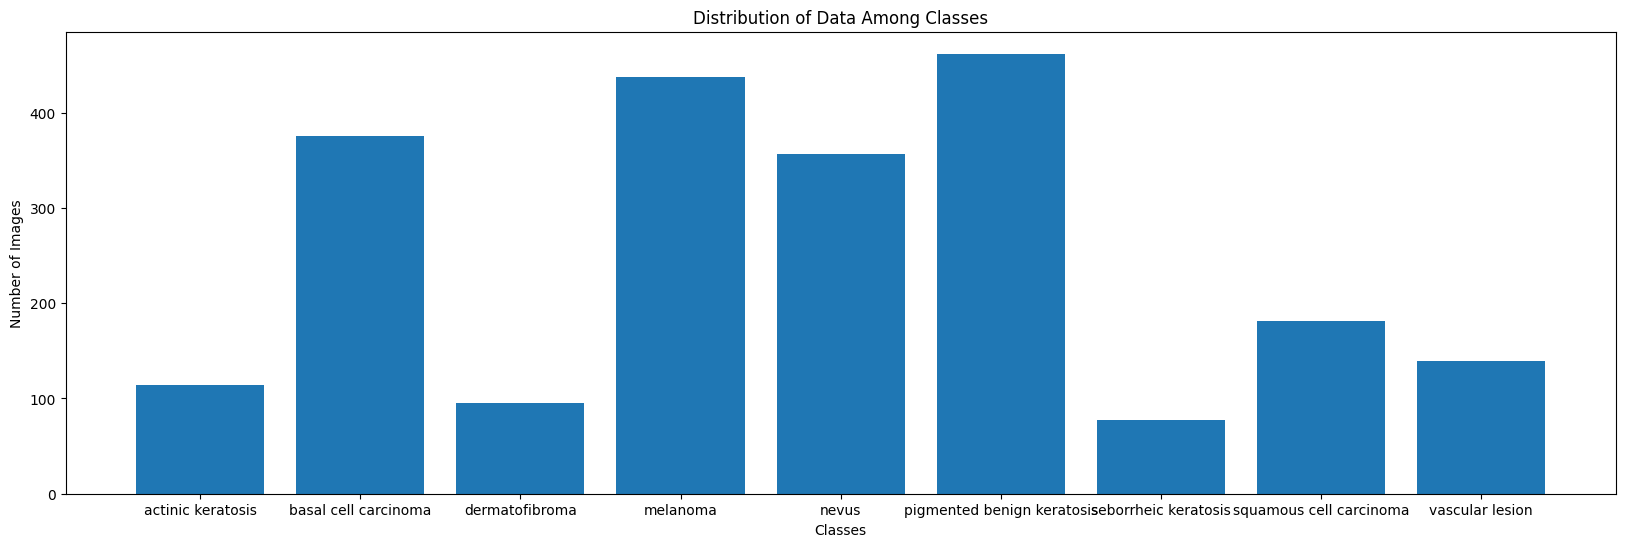

In [21]:
dataset_path = 'skin_cancer_data_augmented/Train/'

class_counts = {}

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    
    # Check if it's a directory
    if os.path.isdir(class_path):
        # Count the number of images in the class folder
        num_images = len(os.listdir(class_path))
        
        # Store the count in the dictionary
        class_counts[class_folder] = num_images

plt.figure(figsize=(20, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Data Among Classes')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [22]:
!pip install Augmentor


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [23]:
path_to_training_dataset="skin_cancer_data_augmented/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to skin_cancer_data_augmented/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17BD078D150>: 100%|█| 500/500 [00:03<00:00, 132.73 Samples


Initialised with 376 image(s) found.
Output directory set to skin_cancer_data_augmented/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17C04ECDC50>: 100%|█| 500/500 [00:03<00:


Initialised with 95 image(s) found.
Output directory set to skin_cancer_data_augmented/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17BD0D91D90>: 100%|█| 500/500 [00:04<00:


Initialised with 438 image(s) found.
Output directory set to skin_cancer_data_augmented/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17C04EC3890>: 100%|█| 500/500 [00:10<00:00, 47.58 Samples


Initialised with 357 image(s) found.
Output directory set to skin_cancer_data_augmented/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x17C04EC28D0>: 100%|█| 500/500 [00:08<00:


Initialised with 462 image(s) found.
Output directory set to skin_cancer_data_augmented/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17BD0CE2D90>: 100%|█| 500/500 [00:04<00:00, 122.70 Samples


Initialised with 77 image(s) found.
Output directory set to skin_cancer_data_augmented/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17BD073EC90>: 100%|█| 500/500 [00:05<00:00, 93.73 Samples


Initialised with 181 image(s) found.
Output directory set to skin_cancer_data_augmented/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17BD0C38650>: 100%|█| 500/500 [00:04<00:00, 119.82 Samples


Initialised with 139 image(s) found.
Output directory set to skin_cancer_data_augmented/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x17BD04B1F90>: 100%|█| 500/500 [00:04<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [24]:
data_dir_train = pathlib.Path("skin_cancer_data_augmented/Train/")
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [25]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['skin_cancer_data_augmented\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_178c4605-0071-41c5-a85a-3880a3b18fed.jpg',
 'skin_cancer_data_augmented\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_55f207d3-5f73-4a71-aa02-297a250e9e42.jpg',
 'skin_cancer_data_augmented\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7c7a3c7c-5409-4408-ab5e-cdc0644f62a1.jpg',
 'skin_cancer_data_augmented\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_88f39880-0e40-4de1-9bc9-487f7c86d286.jpg',
 'skin_cancer_data_augmented\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_3ab24948-828c-4d53-b137-919f690c8c74.jpg',
 'skin_cancer_data_augmented\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_6635dd98-1d70-4977-9fe1-108865cc8821.jpg',
 'skin_cancer_data_augmented\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISI

In [26]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [27]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [28]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns = ['Path','Label'])

In [29]:
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [30]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [31]:
data_dir_train="skin_cancer_data_augmented/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [33]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional: Dropout for regularization

# Output layer
num_classes = 9
model.add(layers.Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [39]:
epochs = 50
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/50
169/169 [==============================] - 84s 495ms/step - loss: 2.1513 - accuracy: 0.1895 - val_loss: 1.7513 - val_accuracy: 0.3385
Epoch 2/50
169/169 [==============================] - 100s 588ms/step - loss: 1.6904 - accuracy: 0.3535 - val_loss: 1.7661 - val_accuracy: 0.3215
Epoch 3/50
169/169 [==============================] - 98s 577ms/step - loss: 1.4905 - accuracy: 0.4305 - val_loss: 1.3684 - val_accuracy: 0.4840
Epoch 4/50
169/169 [==============================] - 98s 576ms/step - loss: 1.3564 - accuracy: 0.4872 - val_loss: 1.1878 - val_accuracy: 0.5486
Epoch 5/50
169/169 [==============================] - 98s 578ms/step - loss: 1.2079 - accuracy: 0.5434 - val_loss: 1.1202 - val_accuracy: 0.5909
Epoch 6/50
169/169 [==============================] - 96s 566ms/step - loss: 1.0909 - accuracy: 0.5933 - val_loss: 1.0073 - val_accuracy: 0.6295
Epoch 7/50
169/169 [==============================] - 95s 559ms/step - loss: 0.9668 - accuracy: 0.6376 - val_loss: 0.9006 - val_a

#### **Todo:**  Visualize the model results

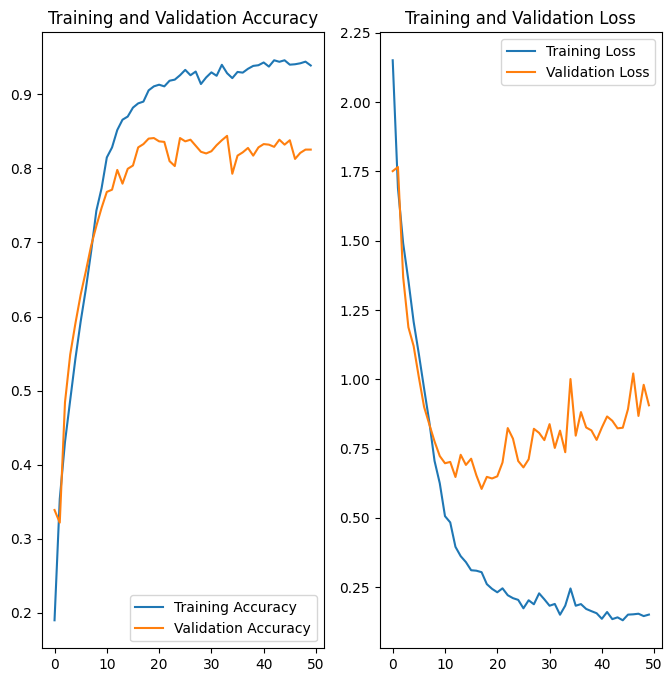

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The class rebalance has yielded a much more accurate model in terms of both training and validation accuracy but the increasing validation loss indicates that the model might still not be complex enough.